# Web scraping project - Complete Machine Learning Notebook
### **Léo RINGEISSEN & Santiago MARTIN - DIA 3**

**This notebook follows the work we did in the previous API and Webscraping notebook :**

In our last submission, we demonstrated how we accessed an SNCF dataset API and webscraped TripAdvisor reviews to produce a dataset containing reviews and emissions data for a variety of travel destinations available by train from Paris.

The text underneath details the adjustments in scope made during the process of producing our dataset.

**Adjustments to the project scope :**

We've learned over the course of this work that a typical method used by companies to prevent bots from illegally scraping their web pages is to deliberately complicate the repetitive tasks a bot would do. 

An example of this is having inconsistent page scrolling, where going to page 2 from page 3 won't be the same as if you'd gone from page 1. Another example is not having simple logic between the URLs of different pages. There are also dynamic elements like text translations that do not get retrieved in the initial soup provided by Selenium.

We initially thought that these were merely poor implementations from TripAdvisor, but we now understand that these inefficiencies are deliberate to prevent any automated web scraping processes from taking place, we can therefore not bypass most of these issues without partnering with or paying TripAdvisor to access their data.

As a result of these limitations, as well as data limitations on the end of the contents of the SNCF API, we've reduced the scope of our project to only trips by train whose origin is Paris and whose destination has a page with sufficient reviews in French on TripAdvisor. In addition, many destinations didn't have review pages at all, so we took the reviews of that destination's most iconic landmark, which would serve as an adequate substitution.

**Data quality and project scalability :**

With these adjustments to the project scope, we end up working with around a third (36) of the itineraries accessible with the API (119), and half of the itineraries whose origin is Paris (75), which still leaves with ample room to make fun and ecological travel recommendations based on traveler preferences and ecological goals, which was the objective we set out to achieve with this project.

Since we couldn't scroll through review pages without being thrown out for bot detection, we resolved the issue by manually selecting the URLs to the first and second review pages (if a second review page is even available). We recognize that this solution would not be scalable for a project with bigger scope, as with more desintations and review pages it would require a lot of manual labor to copy all of the URLs by hand. Fortunately, for the goals of this project which are to learn to web scrape data and utilize it for Machine Learning applications, this is not a concern and we can still move forward with our project.

Using automated google engine searches to automatically find URLs was not a viable option too, as the google search engine results are also made difficult to use via a bot, and we still would have to manually monitor the quality of the first urls yielded by our bot, so it would need more complex and powerful libraries than selenium to be crate a more scalable solution.

**Final CSV generation :**

By the end of the dataset production notebook we generate an aggregated and a non-aggregated CSV file containing our API and web scraped data. The columns are origin, destination, links for first and second review pages, distance between origin and destination, train trip carbon emissions, the scraped URL (only in the non-aggregated file), the review title (concatenated in the aggregated file), the review content (concatenated in the aggregated file), and the review rating (averaged in the aggregated file).

# Importing and exploring our produced dataset

In [2]:
import pandas as pd

agg_df = pd.read_csv('aggregated_emissions_and_reviews.csv', sep=',')
print(agg_df.shape)
print(agg_df.dtypes)
print(agg_df.isnull().sum())
display(agg_df.head())

(36, 9)
origine             object
destination         object
page1_link          object
page2_link          object
distance           float64
train_emissions    float64
titles              object
reviews             object
average_rating     float64
dtype: object
origine             0
destination         0
page1_link          0
page2_link         22
distance            0
train_emissions     0
titles              0
reviews             0
average_rating      0
dtype: int64


,origine,destination,page1_link,page2_link,distance,train_emissions,titles,reviews,average_rating
0,Paris Gare de Lyon,Annecy,https://www.tripadvisor.fr/ShowUserReviews-g18...,https://www.tripadvisor.fr/ShowUserReviews-g18...,545.00,1.580500,“Annecyyyy...!!! Quand tu nous tiens..!!!” || ...,"Vtt sur le Semnoz, pédalo sur le lac, promenad...",4.400000
1,Paris Gare de Lyon,Zuerich HB,https://www.tripadvisor.fr/ShowUserReviews-g18...,NaN,614.00,2.087600,“Zurich le temps d'un weekend”,Une ville riche et agréable ou le centre histo...,5.000000
2,Paris Saint-Lazare,Rouen Rive Droite,https://www.tripadvisor.fr/ShowUserReviews-g18...,https://www.tripadvisor.fr/ShowUserReviews-g18...,139.00,3.391600,“la cathédrale est de plus en plus belle!” || ...,"il faisait un temps moyen,mais le poissonnier ...",4.142857
3,Paris Montparnasse,La Rochelle,https://www.tripadvisor.fr/ShowUserReviews-g18...,NaN,460.00,1.334000,la mentalité à revoir || Charmant || Plaisant ...,les employés dans les magasins au centre de la...,4.333333
4,Paris Gare de Lyon,Grenoble,https://www.tripadvisor.fr/ShowUserReviews-g18...,NaN,556.09,1.612661,“Ma ville” || “ville etudiante et sky”,"Au coeur des montagnes, hiver comme été, Greno...",4.000000


# Data Cleaning and Preprocessing

In [3]:
agg_df.drop(columns=['origine','page1_link', 'page2_link', 'titles'], inplace=True)
display(agg_df.head())

,destination,distance,train_emissions,reviews,average_rating
0,Annecy,545.00,1.580500,"Vtt sur le Semnoz, pédalo sur le lac, promenad...",4.400000
1,Zuerich HB,614.00,2.087600,Une ville riche et agréable ou le centre histo...,5.000000
2,Rouen Rive Droite,139.00,3.391600,"il faisait un temps moyen,mais le poissonnier ...",4.142857
3,La Rochelle,460.00,1.334000,les employés dans les magasins au centre de la...,4.333333
4,Grenoble,556.09,1.612661,"Au coeur des montagnes, hiver comme été, Greno...",4.000000


In [4]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
stopwords = set(stopwords.words('french')) 

def clean_text(text):
    text = text.lower()
    regex_tokenizer = RegexpTokenizer('\w\w+')
    text = regex_tokenizer.tokenize(text)
    text = [word for word in text if word not in stopwords]
    lemma = WordNetLemmatizer()
    text = [lemma.lemmatize(word) for word in text]
    text = ' '.join(text)
    return text

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ringi_3xz04z7\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ringi_3xz04z7\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
corpus = agg_df['reviews'].tolist()
print(corpus[0])
tokenized_corpus = [doc.split(' ') for doc in corpus]
print(tokenized_corpus[0])
processed_corpus = [clean_text(doc) for doc in corpus]
print(processed_corpus[0])
processed_tokenized_corpus = [doc.split(' ') for doc in processed_corpus]
print(processed_tokenized_corpus[0])

Vtt sur le Semnoz, pédalo sur le lac, promenade au bord de l'eau (superbe), l'ambiance de la vielle ville, pti resto super sympa... vraiment vraiment bien.... I love Annecy .... :-) || ville magnifique avec beaucoup de charme quand je vais a annecy j ai l impresssion de ne plus etre en francepas mal de choses a visiter notamment les gorges du fier non loin du centre balade en bateau sur le lac vieille ville typiqueet de tres bons restaurants mais aussi un joli marche le dimanche || Cet endroit est exceptionnel c'est d'ailleurs pour cela que plusieurs personnes traversent la France pour venir apprécier ce lac.Surtout agréable en été avec ses différentes animations dansantes ou artistiques.Lieu de convivialité pour aussi bien se balader, se poser sur la pelouse ou bien faire du pédalo l'été pour pouvoir explorer les différents horizons du lac et ses verdures. || Vous pouvez y trouver tout: les montagnes pour les randonnées, le lac avec de l'eau transparente pour se baigner et les rues an

# Model Experimentation

In [6]:
import random

n_queries = 36
random.seed(42)
query_ids = random.sample(range(len(corpus)), n_queries)
print(query_ids)

[7, 1, 17, 15, 14, 4, 23, 3, 21, 29, 33, 2, 18, 13, 34, 0, 24, 6, 35, 16, 20, 8, 28, 11, 10, 31, 26, 22, 25, 30, 19, 32, 27, 5, 12, 9]


In [7]:
model_results = {}

## BM25 without NLP preprocessing

In [8]:
import numpy as np
from rank_bm25 import BM25Okapi


bm25 = BM25Okapi(tokenized_corpus)

errors = []
best_doc_ids = []

for query_id in query_ids:
    query = corpus[query_id]
    tokenized_query = query.split(" ")
    doc_scores = bm25.get_scores(tokenized_query)
    doc_id = doc_scores.argsort()[-2]
    best_doc_ids.append(doc_id)
    abs_error = abs(agg_df.iloc[query_id]['average_rating'] - agg_df.iloc[doc_id]['average_rating'])
    errors.append(abs_error)
    
# Calculate the mean ERROR
mean_error_bm25_baseline = np.mean(errors)
print(errors)
print(mean_error_bm25_baseline)
print(best_doc_ids)
model_results['bm25_baseline'] = mean_error_bm25_baseline

[0.20000000000000018, 0.5999999999999996, 0.7000000000000002, 0.6000000000000001, 1.3666666666666671, 0.7000000000000002, 0.666666666666667, 0.9333333333333331, 0.5, 0.666666666666667, 0.20000000000000018, 0.24285714285714333, 0.6000000000000001, 0.20000000000000018, 0.4666666666666668, 0.2999999999999998, 0.7000000000000002, 0.8666666666666667, 0.22857142857142865, 0.3666666666666667, 0.8000000000000003, 0.033333333333333215, 0.5, 0.40000000000000036, 1.3666666666666671, 0.5, 0.8000000000000003, 0.6666666666666665, 0.7000000000000002, 2.0333333333333337, 0.5, 0.20000000000000018, 0.023809523809523725, 0.0, 0.16666666666666696, 0.4333333333333331]
0.5619047619047621
[20, 0, 20, 17, 20, 20, 17, 15, 17, 17, 17, 26, 26, 20, 28, 20, 20, 20, 28, 28, 26, 20, 20, 17, 20, 17, 20, 13, 20, 20, 3, 20, 2, 20, 3, 26]


## BM25 with NLP preprocessing

In [9]:
import numpy as np
from rank_bm25 import BM25Okapi

processed_bm25 = BM25Okapi(processed_tokenized_corpus)

processed_errors = []
processed_best_doc_ids = []

for query_id in query_ids:
    query = processed_corpus[query_id]
    tokenized_query = query.split(" ")
    doc_scores = processed_bm25.get_scores(tokenized_query)
    doc_id = doc_scores.argsort()[-2]
    processed_best_doc_ids.append(doc_id)
    abs_error = abs(agg_df.iloc[query_id]['average_rating'] - agg_df.iloc[doc_id]['average_rating'])
    processed_errors.append(abs_error)
    
# Calculate the mean ERROR
mean_error_bm25_preprocessed = np.mean(processed_errors)
print(processed_errors)
print(mean_error_bm25_preprocessed)
print(processed_best_doc_ids)
model_results['bm25_preprocessed'] = mean_error_bm25_preprocessed

[0.20000000000000018, 0.5, 0.10000000000000009, 0.6000000000000001, 0.8666666666666671, 0.40000000000000036, 0.16666666666666696, 0.9333333333333331, 0.5, 0.666666666666667, 0.20000000000000018, 0.35714285714285676, 0.20000000000000018, 0.20000000000000018, 0.4666666666666668, 0.2999999999999998, 0.14285714285714324, 0.30952380952380976, 0.22857142857142865, 0.3666666666666667, 0.8000000000000003, 0.033333333333333215, 0.20000000000000018, 0.09999999999999964, 0.666666666666667, 0.16666666666666696, 0.10000000000000009, 0.8666666666666667, 0.5, 1.5333333333333337, 0.9333333333333331, 0.5, 0.033333333333333215, 0.0, 0.2999999999999998, 0.33333333333333304]
0.41031746031746036
[20, 18, 26, 17, 28, 0, 13, 15, 17, 17, 17, 13, 5, 20, 28, 20, 2, 2, 28, 28, 26, 5, 0, 13, 24, 9, 17, 20, 13, 28, 26, 24, 28, 20, 28, 24]


## TFIDF without NLP preprocessing

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Build TF-IDF matrix
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(corpus)

errors = []
best_doc_ids = []

# Iterate through random queries
for query_id in query_ids:
    query = corpus[query_id]
    query_vector = tfidf.transform([query])
    doc_scores = cosine_similarity(query_vector, tfidf_matrix).flatten()
    doc_id = np.argsort(doc_scores)[-2]  # Second-highest score
    best_doc_ids.append(doc_id)
    abs_error = abs(agg_df.iloc[query_id]['average_rating'] - agg_df.iloc[doc_id]['average_rating'])
    errors.append(abs_error)

mean_error_tf_baseline = np.mean(errors)
print(errors)
print(mean_error_tf_baseline)
print(best_doc_ids)
model_results['tfidf_baseline'] = mean_error_tf_baseline

[0.20000000000000018, 0.5999999999999996, 0.7000000000000002, 0.6000000000000001, 1.3666666666666671, 0.7000000000000002, 0.033333333333333215, 0.33333333333333304, 1.1, 0.666666666666667, 0.20000000000000018, 0.14285714285714324, 0.20000000000000018, 0.20000000000000018, 0.4666666666666668, 0.2999999999999998, 0.7000000000000002, 0.8666666666666667, 0.27142857142857135, 0.8666666666666667, 0.7000000000000002, 0.033333333333333215, 0.5, 0.2999999999999998, 1.3666666666666671, 0.20000000000000018, 0.8000000000000003, 0.6666666666666665, 0.7000000000000002, 2.0333333333333337, 0.9333333333333331, 0.20000000000000018, 0.033333333333333215, 0.0, 0.20000000000000018, 0.33333333333333304]
0.542063492063492
[20, 0, 20, 17, 20, 20, 20, 17, 15, 17, 17, 17, 20, 20, 28, 20, 20, 20, 20, 20, 17, 20, 20, 20, 20, 20, 20, 13, 20, 20, 26, 20, 28, 20, 20, 17]


## TFIDF with NLP preprocessing

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Build TF-IDF matrix
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(processed_corpus)

preprocessed_errors = []
best_doc_ids = []

# Iterate through random queries
for query_id in query_ids:
    query = processed_corpus[query_id]
    query_vector = tfidf.transform([query])
    doc_scores = cosine_similarity(query_vector, tfidf_matrix).flatten()
    doc_id = np.argsort(doc_scores)[-2]  # Second-highest score
    best_doc_ids.append(doc_id)
    abs_error = abs(agg_df.iloc[query_id]['average_rating'] - agg_df.iloc[doc_id]['average_rating'])
    preprocessed_errors.append(abs_error)

mean_error_tf_preprocessed = np.mean(preprocessed_errors)
print(preprocessed_errors)
print(mean_error_tf_preprocessed)
print(best_doc_ids)
model_results['tfidf_preprocessed'] = mean_error_tf_preprocessed

[0.20000000000000018, 0.5999999999999996, 0.10000000000000009, 0.6000000000000001, 0.8666666666666671, 0.40000000000000036, 0.666666666666667, 0.9333333333333331, 0.5, 0.666666666666667, 0.20000000000000018, 0.35714285714285676, 0.09999999999999964, 0.20000000000000018, 0.033333333333333215, 0.2999999999999998, 0.14285714285714324, 0.16666666666666652, 0.22857142857142865, 0.3666666666666667, 0.7000000000000002, 0.666666666666667, 0.5, 0.40000000000000036, 0.666666666666667, 0.16666666666666696, 0.10000000000000009, 0.8666666666666667, 0.7000000000000002, 1.3333333333333335, 0.9333333333333331, 0.09999999999999964, 0.33333333333333304, 0.7000000000000002, 0.0, 0.4333333333333331]
0.45079365079365086
[20, 0, 26, 17, 28, 0, 17, 15, 17, 17, 17, 13, 0, 20, 5, 20, 2, 17, 28, 28, 17, 17, 5, 17, 17, 9, 17, 20, 20, 17, 26, 0, 12, 17, 13, 26]


## Flan T5 without NLP preprocessing

In [12]:
from transformers import T5Tokenizer, T5Model
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import random
import sentencepiece
import torch

In [13]:
from transformers import T5Tokenizer, T5Model
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import random
import sentencepiece
import torch

# Load T5 model and tokenizer
model_name = "t5-base"  # Change to "t5-base" or "t5-large" for better results
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5Model.from_pretrained(model_name)

# Ensure reproducibility
random.seed(42)
np.random.seed(42)

# Function to encode text into embeddings using T5
def encode_text(text, max_length=512):
    # Tokenize and prepare inputs
    inputs = tokenizer(text, return_tensors="pt", max_length=max_length, truncation=True, padding="max_length")
    # Pass inputs through T5 encoder to get embeddings
    with torch.no_grad():
        outputs = model.encoder(**inputs)
    # Mean pooling of the token embeddings
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# Preprocess corpus to get embeddings
print("Encoding documents into embeddings...")
document_embeddings = np.array([encode_text(doc) for doc in corpus])

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Encoding documents into embeddings...


In [14]:
errors = []
best_doc_ids = []

# Iterate through random queries
print("Processing queries...")
for query_id in query_ids:
    query = corpus[query_id]
    query_embedding = encode_text(query)
    
    # Compute cosine similarities
    doc_scores = cosine_similarity([query_embedding], document_embeddings).flatten()
    
    # Get the second-highest score
    doc_id = np.argsort(doc_scores)[-2]  # Second-highest score
    best_doc_ids.append(doc_id)
    
    # Calculate MSE for evaluation
    abs_error = abs(agg_df.iloc[query_id]['average_rating'] - agg_df.iloc[doc_id]['average_rating'])
    errors.append(abs_error)

# Calculate the mean ERROR
mean_errors_t5s_baseline = np.mean(errors)
print(errors)
print(f"Mean ERROR: {mean_errors_t5s_baseline}")
print("Best doc IDs:", best_doc_ids)
model_results['t5s_baseline'] = mean_errors_t5s_baseline

Processing queries...
[0.09999999999999964, 0.5, 0.666666666666667, 0.8000000000000003, 0.8095238095238102, 0.5, 0.666666666666667, 1.0, 0.16666666666666696, 1.333333333333334, 0.8000000000000003, 0.8095238095238102, 0.5, 0.35714285714285676, 0.16666666666666696, 0.2666666666666666, 0.666666666666667, 0.3666666666666667, 0.07142857142857117, 0.0, 1.3666666666666671, 0.4666666666666668, 0.05714285714285694, 0.06666666666666732, 1.0, 0.6666666666666665, 0.10000000000000009, 0.0, 0.666666666666667, 1.8333333333333335, 0.833333333333333, 1.166666666666667, 0.33333333333333304, 0.033333333333333215, 0.6666666666666665, 0.13333333333333286]
Mean ERROR: 0.5538359788359789
Best doc IDs: [0, 18, 8, 33, 2, 18, 25, 10, 8, 23, 15, 14, 4, 2, 12, 8, 14, 28, 7, 22, 14, 28, 2, 9, 3, 22, 17, 16, 23, 12, 4, 14, 18, 8, 16, 28]


## Flan TF with NLP preprocessing

In [15]:
# Load T5 model and tokenizer
model_name = "t5-base"  # Change to "t5-base" or "t5-large" for better results
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5Model.from_pretrained(model_name)

# Ensure reproducibility
random.seed(42)
np.random.seed(42)

# Function to encode text into embeddings using T5
def encode_text(text, max_length=512):
    # Tokenize and prepare inputs
    inputs = tokenizer(text, return_tensors="pt", max_length=max_length, truncation=True, padding="max_length")
    # Pass inputs through T5 encoder to get embeddings
    with torch.no_grad():
        outputs = model.encoder(**inputs)
    # Mean pooling of the token embeddings
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# Preprocess corpus to get embeddings
print("Encoding documents into embeddings...")
document_embeddings = np.array([encode_text(doc) for doc in processed_corpus])

Encoding documents into embeddings...


In [16]:
processed_errors = []
best_doc_ids = []

# Iterate through random queries
print("Processing queries...")
for query_id in query_ids:
    query = processed_corpus[query_id]
    query_embedding = encode_text(query)
    
    # Compute cosine similarities
    doc_scores = cosine_similarity([query_embedding], document_embeddings).flatten()
    
    # Get the second-highest score
    doc_id = np.argsort(doc_scores)[-2]  # Second-highest score
    best_doc_ids.append(doc_id)
    
    # Calculate MSE for evaluation
    abs_error = abs(agg_df.iloc[query_id]['average_rating'] - agg_df.iloc[doc_id]['average_rating'])
    processed_errors.append(abs_error)

# Calculate the mean ERROR
mean_error_t5s_preprocessed = np.mean(processed_errors)
print(preprocessed_errors)
print(f"Mean ERROR: {mean_error_tf_preprocessed}")
print("Best doc IDs:", best_doc_ids)
model_results['t5s_preprocessed'] = mean_error_t5s_preprocessed

Processing queries...
[0.20000000000000018, 0.5999999999999996, 0.10000000000000009, 0.6000000000000001, 0.8666666666666671, 0.40000000000000036, 0.666666666666667, 0.9333333333333331, 0.5, 0.666666666666667, 0.20000000000000018, 0.35714285714285676, 0.09999999999999964, 0.20000000000000018, 0.033333333333333215, 0.2999999999999998, 0.14285714285714324, 0.16666666666666652, 0.22857142857142865, 0.3666666666666667, 0.7000000000000002, 0.666666666666667, 0.5, 0.40000000000000036, 0.666666666666667, 0.16666666666666696, 0.10000000000000009, 0.8666666666666667, 0.7000000000000002, 1.3333333333333335, 0.9333333333333331, 0.09999999999999964, 0.33333333333333304, 0.7000000000000002, 0.0, 0.4333333333333331]
Mean ERROR: 0.45079365079365086
Best doc IDs: [28, 19, 33, 28, 23, 27, 14, 10, 11, 14, 26, 13, 34, 2, 16, 28, 13, 35, 6, 34, 7, 11, 0, 21, 3, 22, 33, 16, 29, 12, 1, 14, 34, 7, 34, 16]


## BERT

In [17]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Encode documents into embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')  # Lightweight BERT-based model
embeddings = model.encode(corpus)

errors = []
best_doc_ids = []

# Iterate through random queries
for query_id in query_ids:
    query = corpus[query_id]
    query_embedding = model.encode([query])
    doc_scores = cosine_similarity(query_embedding, embeddings).flatten()
    doc_id = np.argsort(doc_scores)[-2]  # Second-highest score
    best_doc_ids.append(doc_id)
    abs_error = abs(agg_df.iloc[query_id]['average_rating'] - agg_df.iloc[doc_id]['average_rating'])
    errors.append(abs_error)

mean_error_bert_baseline = np.mean(errors)
print(errors)
print(mean_error_bert_baseline)
print(best_doc_ids)
model_results['bert_baseline'] = mean_error_bert_baseline
bert_model=model

[0.09999999999999964, 0.16666666666666696, 0.0, 0.6000000000000001, 0.8666666666666671, 0.5, 1.333333333333334, 0.16666666666666696, 0.16666666666666696, 0.8666666666666671, 0.3666666666666667, 1.4761904761904767, 0.16666666666666696, 0.5, 0.5, 0.2666666666666666, 0.5, 0.3666666666666667, 0.02857142857142847, 0.3666666666666667, 0.033333333333333215, 0.033333333333333215, 0.8666666666666671, 0.5666666666666669, 0.666666666666667, 0.0, 0.6000000000000001, 0.6666666666666665, 0.5, 2.0000000000000004, 0.33333333333333304, 0.16666666666666696, 0.33333333333333304, 0.20000000000000018, 0.6666666666666665, 0.33333333333333304]
0.4797619047619049
[11, 19, 24, 24, 28, 18, 29, 18, 8, 28, 22, 30, 3, 25, 27, 34, 12, 28, 0, 28, 8, 20, 29, 22, 25, 13, 18, 12, 13, 34, 12, 3, 12, 12, 22, 25]


In [18]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Encode documents into embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')  # Lightweight BERT-based model
embeddings = model.encode(processed_corpus)

processed_errors = []
best_doc_ids = []

# Iterate through random queries
for query_id in query_ids:
    query = processed_corpus[query_id]
    query_embedding = model.encode([query])
    doc_scores = cosine_similarity(query_embedding, embeddings).flatten()
    doc_id = np.argsort(doc_scores)[-2]  # Second-highest score
    best_doc_ids.append(doc_id)
    abs_error = abs(agg_df.iloc[query_id]['average_rating'] - agg_df.iloc[doc_id]['average_rating'])
    processed_errors.append(abs_error)

mean_error_bert_preprocessed = np.mean(processed_errors)
print(processed_errors)
print(mean_error_bert_preprocessed)
print(best_doc_ids)
model_results['bert_preprocessed'] = mean_error_bert_preprocessed

[0.16666666666666696, 0.5999999999999996, 1.3333333333333335, 0.8000000000000003, 0.8666666666666671, 0.5, 0.5, 0.09523809523809579, 0.5, 0.8095238095238102, 0.3666666666666667, 0.05714285714285694, 0.09999999999999964, 0.09999999999999964, 2.0000000000000004, 0.02857142857142847, 0.40000000000000036, 0.3666666666666667, 0.02857142857142847, 0.3666666666666667, 0.033333333333333215, 0.3333333333333339, 0.05714285714285694, 0.5666666666666669, 1.0, 0.07142857142857117, 0.5000000000000004, 0.3666666666666667, 0.666666666666667, 1.8333333333333335, 0.9999999999999996, 0.2999999999999998, 1.5000000000000004, 0.033333333333333215, 1.8333333333333335, 0.06666666666666732]
0.5596560846560846
[9, 11, 30, 33, 28, 18, 27, 35, 17, 2, 22, 28, 0, 0, 30, 35, 0, 28, 0, 28, 8, 3, 2, 22, 3, 35, 0, 33, 23, 12, 22, 28, 30, 34, 30, 0]


## Results comparision

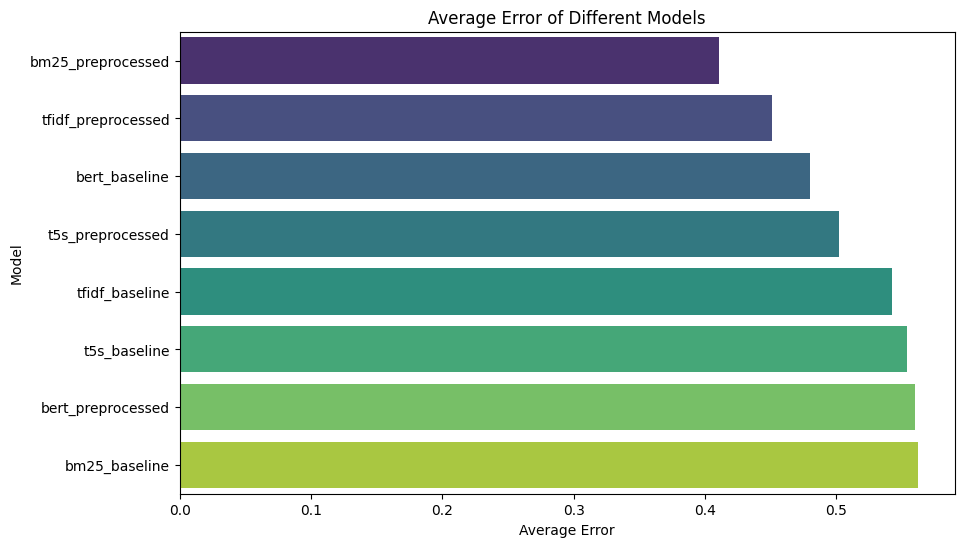

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

results_df = pd.DataFrame.from_dict(model_results, orient='index', columns=['ERROR'])
results_df = results_df.reset_index().rename(columns={'index': 'Model'})
results_df = results_df.sort_values('ERROR')

plt.figure(figsize=(10, 6))
sns.barplot(x='ERROR', y='Model', data=results_df, palette='viridis', hue='Model')
plt.title('Average Error of Different Models')
plt.xlabel('Average Error')

plt.show()

# Recommendation based on review and emissions

## Only BM25

In [ ]:
import numpy as np
from rank_bm25 import BM25Okapi

# Assuming processed_bm25 and processed_corpus are already loaded
# processed_bm25 = BM25Okapi(processed_tokenized_corpus)
# processed_corpus = [your list of documents]
# destinations = [list of destinations corresponding to processed_corpus]

# Function to preprocess the user input (tokenization)
def preprocess_input(user_input):
    return user_input.split(" ")

# Function to predict the top 3 documents based on BM25
def predict_top_3(user_input, bm25_model, corpus, destinations):
    # Preprocess the user input (tokenization)
    tokenized_query = preprocess_input(user_input)
    
    # Get the document scores for the query
    doc_scores = bm25_model.get_scores(tokenized_query)
    
    # Get the indices of the top 3 documents (highest scores)
    top_3_idx = np.argsort(doc_scores)[-3:][::-1]  # Sort and get the top 3 (in descending order)
    
    # Retrieve the destinations and documents corresponding to the top 3 matches
    top_3_results = []
    for idx in top_3_idx:
        best_match_document = corpus[idx]
        best_match_destination = destinations[idx]
        top_3_results.append((best_match_destination, best_match_document, doc_scores[idx]))
    
    return top_3_results

# Prompt the user for input (a query)
user_input = input("Please enter your travel review query: ")

# Get the prediction (top 3 matches and their destinations)
top_3_results = predict_top_3(user_input, processed_bm25, processed_tokenized_corpus, agg_df.destination)

# Display the results
print("\nTop 3 Matches:")
for result in top_3_results:
    destination, document, score = result
    print(f"Destination: {destination}\nDocument: {document}\nScore: {score}\n")



Top 3 Matches:
Destination: Bruxelles N Aero
Document: ['amour', 'porte', 'ville', 'dépend', 'évidemment', 'cherche', 'lu', 'commentaires', 'négatifs', 'rome', 'paris', 'trouve', 'personnellement', 'admirables', 'bruxelles', 'taille', 'grande', 'ville', 'province', 'peine', 'deux', 'million', 'habitant', 'grande', 'banlieue', 'peut', 'donc', 'comparer', 'paris', 'londres', 'rome', 'proportionnellement', 'taille', 'ville', 'riche', 'musées', 'oeuvre', 'art', 'tout', 'fait', 'remarquables', 'crois', 'déplorable', 'service', 'touristique', 'cette', 'ville', 'mette', 'trop', 'accent', 'exception', 'grand', 'place', 'plus', 'médiocre', 'manneken', 'pi', 'atomium', 'assez', 'médiocres', 'restaurant', 'rue', 'bouchers', 'plus', 'populaire', 'habite', 'cette', 'ville', 'depuis', 'nombre', 'années', 'trouve', 'agréable', 'vivre', 'bons', 'cinémas', 'bons', 'théâtres', 'excellentes', 'salles', 'concert', 'surtout', 'appartements', 'très', 'confortables', 'prix', 'relativement', 'abordables', 'e

## Ensemble prediction
### BM25 preprocessed + TF-IDF preprocessed + BERT

In [43]:
import numpy as np
from rank_bm25 import BM25Okapi
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

# Assuming processed_bm25, processed_corpus, agg_df, and destinations are already loaded

# Define the preprocessing function for user input (same as before)
def preprocess_input(user_input):
    return user_input.split(" ")

# BM25 model
def predict_bm25(user_input, bm25_model, corpus, destinations):
    tokenized_query = preprocess_input(user_input)
    doc_scores = bm25_model.get_scores(tokenized_query)
    top_3_idx = np.argsort(doc_scores)[-3:][::-1]
    
    top_3_results = []
    for idx in top_3_idx:
        best_match_document = corpus[idx]
        best_match_destination = destinations[idx]
        top_3_results.append((best_match_destination, best_match_document, doc_scores[idx]))
    
    return top_3_results

# TF-IDF model
def predict_tfidf(user_input, tfidf_matrix, tfidf, corpus, destinations):
    query_vector = tfidf.transform([user_input])
    doc_scores = cosine_similarity(query_vector, tfidf_matrix).flatten()
    top_3_idx = np.argsort(doc_scores)[-3:][::-1]
    
    top_3_results = []
    for idx in top_3_idx:
        best_match_document = corpus[idx]
        best_match_destination = destinations[idx]
        top_3_results.append((best_match_destination, best_match_document, doc_scores[idx]))
    
    return top_3_results

# BERT model
def predict_bert(user_input, model, embeddings, corpus, destinations):
    query_embedding = model.encode([user_input])
    doc_scores = cosine_similarity(query_embedding, embeddings).flatten()
    top_3_idx = np.argsort(doc_scores)[-3:][::-1]
    
    top_3_results = []
    for idx in top_3_idx:
        best_match_document = corpus[idx]
        best_match_destination = destinations[idx]
        top_3_results.append((best_match_destination, best_match_document, doc_scores[idx]))
    
    return top_3_results

# Ensemble model
def ensemble_predict(user_input, bm25_model, tfidf_matrix, tfidf, model, embeddings, corpus, destinations):
    # Get predictions from each model
    bm25_results = predict_bm25(user_input, bm25_model, corpus, destinations)
    tfidf_results = predict_tfidf(user_input, tfidf_matrix, tfidf, corpus, destinations)
    bert_results = predict_bert(user_input, model, embeddings, corpus, destinations)
    
    # Combine the results from all models
    combined_results = {}
    for result in bm25_results + tfidf_results + bert_results:
        destination, document, score = result
        if destination not in combined_results:
            combined_results[destination] = []
        combined_results[destination].append(score)
    
    # Calculate the average score for each destination
    averaged_results = []
    for destination, scores in combined_results.items():
        avg_score = np.mean(scores)
        averaged_results.append((destination, avg_score))
    
    # Sort by average score and return top 3
    averaged_results.sort(key=lambda x: x[1], reverse=True)
    top_3_ensemble = averaged_results[:3]
    
    return top_3_ensemble

# Load the pre-trained models and other variables
# Example: processed_bm25, processed_corpus, tfidf_matrix, tfidf, model (BERT), embeddings, destinations

# User input query
user_input = input("Please enter your travel review query: ")

# Get the ensemble prediction
top_3_ensemble = ensemble_predict(user_input, processed_bm25, tfidf_matrix, tfidf, bert_model, embeddings, processed_corpus, agg_df.destination)

# Display the top 3 results
print("\nTop 3 Ensemble Predictions:")
for destination, score in top_3_ensemble:
    print(f"Destination: {destination}\nScore: {score}\n")



Top 3 Ensemble Predictions:
Destination: Annecy
Score: 0.42992353439331055

Destination: Milano P Garibaldi
Score: 0.4010082185268402

Destination: Geneve
Score: 0.39729994535446167



## Functional streamlit app 

In [49]:
## Export models

import pickle
import os

# Create the 'app_models' directory if it doesn't exist
if not os.path.exists('app_models'):
    os.makedirs('app_models')

# Export BM25 model
with open("app_models/processed_bm25.pkl", "wb") as f:
    pickle.dump(processed_bm25, f)

# Export TF-IDF vectorizer and matrix
with open("app_models/tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf, f)

with open("app_models/tfidf_matrix.pkl", "wb") as f:
    pickle.dump(tfidf_matrix, f)

# Export BERT model
with open("app_models/bert_model.pkl", "wb") as f:
    pickle.dump(bert_model, f)

# Export embeddings
with open("app_models/embeddings.pkl", "wb") as f:
    pickle.dump(embeddings, f)

# Export processed_corpus and agg_df.destination (if required)
with open("app_models/processed_corpus.pkl", "wb") as f:
    pickle.dump(processed_corpus, f)

with open("app_models/agg_df_destination.pkl", "wb") as f:
    pickle.dump(agg_df.destination, f)

with open("app_models/agg_df_train_emissions.pkl", "wb") as f:
    pickle.dump(agg_df.train_emissions, f)



## app with no balance between f1 and emissions

In [3]:
# Save the app code to a Python file and run Streamlit
streamlit_code = """
import streamlit as st
import numpy as np
from rank_bm25 import BM25Okapi
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import pandas as pd
import pickle
import os

# Define the path to the app_models folder
models_path = 'app_models/'

# Load BM25 model
with open(os.path.join(models_path, "processed_bm25.pkl"), "rb") as f:
    processed_bm25 = pickle.load(f)

# Load TF-IDF vectorizer and matrix
with open(os.path.join(models_path, "tfidf_vectorizer.pkl"), "rb") as f:
    tfidf = pickle.load(f)

with open(os.path.join(models_path, "tfidf_matrix.pkl"), "rb") as f:
    tfidf_matrix = pickle.load(f)

# Load BERT model
with open(os.path.join(models_path, "bert_model.pkl"), "rb") as f:
    bert_model = pickle.load(f)

# Load embeddings
with open(os.path.join(models_path, "embeddings.pkl"), "rb") as f:
    embeddings = pickle.load(f)

# Load processed_corpus and agg_df.destination (if required)
with open(os.path.join(models_path, "processed_corpus.pkl"), "rb") as f:
    processed_corpus = pickle.load(f)

with open(os.path.join(models_path, "agg_df_destination.pkl"), "rb") as f:
    agg_df_destination = pickle.load(f)

# Load the emissions data (agg_df_train_emissions)
with open(os.path.join(models_path, "agg_df_train_emissions.pkl"), "rb") as f:
    agg_df_train_emissions = pickle.load(f)

# Define the preprocessing function for user input
def preprocess_input(user_input):
    return user_input.split(" ")

# BM25 model prediction
def predict_bm25(user_input, bm25_model, corpus, destinations):
    tokenized_query = preprocess_input(user_input)
    doc_scores = bm25_model.get_scores(tokenized_query)
    top_3_idx = np.argsort(doc_scores)[-3:][::-1]
    
    top_3_results = []
    for idx in top_3_idx:
        best_match_document = corpus[idx]
        best_match_destination = destinations[idx]
        top_3_results.append((best_match_destination, best_match_document, doc_scores[idx]))
    
    return top_3_results

# TF-IDF model prediction
def predict_tfidf(user_input, tfidf_matrix, tfidf, corpus, destinations):
    query_vector = tfidf.transform([user_input])
    doc_scores = cosine_similarity(query_vector, tfidf_matrix).flatten()
    top_3_idx = np.argsort(doc_scores)[-3:][::-1]
    
    top_3_results = []
    for idx in top_3_idx:
        best_match_document = corpus[idx]
        best_match_destination = destinations[idx]
        top_3_results.append((best_match_destination, best_match_document, doc_scores[idx]))
    
    return top_3_results

# BERT model prediction
def predict_bert(user_input, model, embeddings, corpus, destinations):
    query_embedding = model.encode([user_input])
    doc_scores = cosine_similarity(query_embedding, embeddings).flatten()
    top_3_idx = np.argsort(doc_scores)[-3:][::-1]
    
    top_3_results = []
    for idx in top_3_idx:
        best_match_document = corpus[idx]
        best_match_destination = destinations[idx]
        top_3_results.append((best_match_destination, best_match_document, doc_scores[idx]))
    
    return top_3_results

def ensemble_predict_with_emissions(user_input, bm25_model, tfidf_matrix, tfidf, model, embeddings, corpus, destinations, emissions_data):
    # Get predictions from each model
    bm25_results = predict_bm25(user_input, bm25_model, corpus, destinations)
    tfidf_results = predict_tfidf(user_input, tfidf_matrix, tfidf, corpus, destinations)
    bert_results = predict_bert(user_input, model, embeddings, corpus, destinations)
    
    # Combine the results from all models
    combined_results = {}
    for result in bm25_results + tfidf_results + bert_results:
        destination, document, score = result
        if destination not in combined_results:
            combined_results[destination] = []
        combined_results[destination].append(score)
    
    # Calculate the average score for each destination and add emissions data
    averaged_results = []
    for destination, scores in combined_results.items():
        avg_score = np.mean(scores)
        
        # Retrieve the emission for the destination from emissions_data (which is a pandas Series)
        try:
            emissions = emissions_data[agg_df_destination == destination].values[0]  # .values[0] to extract the scalar value
        except IndexError:
            emissions = 0  # Default to 0 if the destination is not found
            
        averaged_results.append((destination, avg_score, emissions))
    
    # Sort by average score and return top 3
    averaged_results.sort(key=lambda x: x[1], reverse=True)
    top_3_ensemble = averaged_results[:3]
    
    return top_3_ensemble

# Streamlit app code with emissions
def run_streamlit_app_with_emissions():
    st.title("Travel Review Prediction with Ensemble Models (Including Emissions)")
    
    # Input field for user query
    user_input = st.text_input("Enter your travel review query:")
    
    if user_input:
        st.write("User input received:", user_input)  # Debugging line

        # Get the ensemble prediction with emissions
        top_3_ensemble_with_emissions = ensemble_predict_with_emissions(user_input, processed_bm25, tfidf_matrix, tfidf, bert_model, embeddings, processed_corpus, agg_df_destination, agg_df_train_emissions)

        if top_3_ensemble_with_emissions:
            st.write("### Top 3 Predictions:")
            for destination, score, emissions in top_3_ensemble_with_emissions:
                st.write(f"**Destination:** {destination}")
                st.write(f"**Score:** {score:.2f}")
                st.write(f"**Emissions (kg CO2):** {emissions:.2f}")
                st.write("---")
        else:
            st.write("No predictions found.")

# Run the Streamlit app with emissions data
run_streamlit_app_with_emissions()

"""

# Save the app code to a file
with open("streamlit_app.py", "w") as f:
    f.write(streamlit_code)

# Run the Streamlit app (in notebook environment)
!streamlit run streamlit_app.py


^C


## With balance

In [4]:
# Save the app code to a Python file and run Streamlit
streamlit_code = """
import streamlit as st
import numpy as np
from rank_bm25 import BM25Okapi
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import pandas as pd
import pickle
import os

# Assuming processed_bm25, processed_corpus, agg_df, and destinations are already loaded

# Define the path to the app_models folder
models_path = 'app_models/'

# Load BM25 model
with open(os.path.join(models_path, "processed_bm25.pkl"), "rb") as f:
    processed_bm25 = pickle.load(f)

# Load TF-IDF vectorizer and matrix
with open(os.path.join(models_path, "tfidf_vectorizer.pkl"), "rb") as f:
    tfidf = pickle.load(f)

with open(os.path.join(models_path, "tfidf_matrix.pkl"), "rb") as f:
    tfidf_matrix = pickle.load(f)

# Load BERT model
with open(os.path.join(models_path, "bert_model.pkl"), "rb") as f:
    bert_model = pickle.load(f)

# Load embeddings
with open(os.path.join(models_path, "embeddings.pkl"), "rb") as f:
    embeddings = pickle.load(f)

# Load processed_corpus and agg_df.destination (if required)
with open(os.path.join(models_path, "processed_corpus.pkl"), "rb") as f:
    processed_corpus = pickle.load(f)

with open(os.path.join(models_path, "agg_df_destination.pkl"), "rb") as f:
    agg_df_destination = pickle.load(f)

# Load the train emissions data
with open(os.path.join(models_path, "agg_df_train_emissions.pkl"), "rb") as f:
    agg_df_train_emissions = pickle.load(f)

# Preprocessing function for user input
def preprocess_input(user_input):
    return user_input.split(" ")

# BM25 model
def predict_bm25(user_input, bm25_model, corpus, destinations):
    tokenized_query = preprocess_input(user_input)
    doc_scores = bm25_model.get_scores(tokenized_query)
    top_3_idx = np.argsort(doc_scores)[-3:][::-1]
    
    top_3_results = []
    for idx in top_3_idx:
        best_match_document = corpus[idx]
        best_match_destination = destinations[idx]
        top_3_results.append((best_match_destination, best_match_document, doc_scores[idx]))
    
    return top_3_results

# TF-IDF model
def predict_tfidf(user_input, tfidf_matrix, tfidf, corpus, destinations):
    query_vector = tfidf.transform([user_input])
    doc_scores = cosine_similarity(query_vector, tfidf_matrix).flatten()
    top_3_idx = np.argsort(doc_scores)[-3:][::-1]
    
    top_3_results = []
    for idx in top_3_idx:
        best_match_document = corpus[idx]
        best_match_destination = destinations[idx]
        top_3_results.append((best_match_destination, best_match_document, doc_scores[idx]))
    
    return top_3_results

# BERT model
def predict_bert(user_input, model, embeddings, corpus, destinations):
    query_embedding = model.encode([user_input])
    doc_scores = cosine_similarity(query_embedding, embeddings).flatten()
    top_3_idx = np.argsort(doc_scores)[-3:][::-1]
    
    top_3_results = []
    for idx in top_3_idx:
        best_match_document = corpus[idx]
        best_match_destination = destinations[idx]
        top_3_results.append((best_match_destination, best_match_document, doc_scores[idx]))
    
    return top_3_results

# Ensemble model
def ensemble_predict(user_input, bm25_model, tfidf_matrix, tfidf, model, embeddings, corpus, destinations):
    # Get predictions from each model
    bm25_results = predict_bm25(user_input, bm25_model, corpus, destinations)
    tfidf_results = predict_tfidf(user_input, tfidf_matrix, tfidf, corpus, destinations)
    bert_results = predict_bert(user_input, model, embeddings, corpus, destinations)
    
    # Combine the results from all models
    combined_results = {}
    for result in bm25_results + tfidf_results + bert_results:
        destination, document, score = result
        if destination not in combined_results:
            combined_results[destination] = []
        combined_results[destination].append(score)
    
    # Calculate the average score for each destination
    averaged_results = []
    for destination, scores in combined_results.items():
        avg_score = np.mean(scores)
        averaged_results.append((destination, avg_score))
    
    # Sort by average score and return top 3
    averaged_results.sort(key=lambda x: x[1], reverse=True)
    top_3_ensemble = averaged_results[:3]
    
    return top_3_ensemble

# Recommendation with Best F1 and Lowest Emissions Balance
def recommend_best_destination_with_balance(top_3_ensemble_with_emissions):
    # Directly calculate F1 score - emissions for each recommendation
    recommendations = []
    for destination, f1_score, emissions in top_3_ensemble_with_emissions:
        combined_score = f1_score - emissions  # F1 score - emissions (no scaling/normalization)
        recommendations.append((destination, combined_score))

    # Get the destination with the highest combined score
    best_destination = max(recommendations, key=lambda x: x[1])[0]
    return best_destination

# Streamlit app code
def run_streamlit_app_with_best_recommendation():
    st.title("Travel Review Prediction with Ensemble Models")
    
    # Input field for user query
    user_input = st.text_input("Enter your travel review query:")
    
    if user_input:
        st.write("User input received:", user_input)  # Debugging line

        # Get the ensemble prediction with emissions
        top_3_ensemble_with_emissions = ensemble_predict(user_input, processed_bm25, tfidf_matrix, tfidf, bert_model, embeddings, processed_corpus, agg_df_destination)

        # Add emissions to the results
        top_3_ensemble_with_emissions_and_emissions = []
        for (destination, score) in top_3_ensemble_with_emissions:
            # Instead of using .index(), use .loc to fetch the emission value
            emissions = agg_df_train_emissions.loc[agg_df_destination == destination].values[0]
            top_3_ensemble_with_emissions_and_emissions.append((destination, score, emissions))

        # Display top 3 predictions with F1 score and emissions
        st.write("### Top 3 Predictions:")
        for destination, score, emissions in top_3_ensemble_with_emissions_and_emissions:
            st.write(f"**Destination:** {destination}")
            st.write(f"**F1 Score:** {score:.2f}")
            st.write(f"**Emissions:** {emissions:.2f} kg CO2")
            st.write("---")
        
        # Get the best destination based on F1 score and emissions balance
        best_destination = recommend_best_destination_with_balance(top_3_ensemble_with_emissions_and_emissions)

        st.write("### Best Recommendation based on F1 Score - Emissions:")
        st.write(f"**Best Destination:** {best_destination}")
        

run_streamlit_app_with_best_recommendation()

"""

# Save the app code to a file
with open("streamlit_app.py", "w") as f:
    f.write(streamlit_code)

# Run the Streamlit app (in notebook environment)
!streamlit run streamlit_app.py


^C


In [1]:
import os
import pickle
models_path = 'app_models/'

with open(os.path.join(models_path, "agg_df_destination.pkl"), "rb") as f:
    agg_df_destination = pickle.load(f)
agg_df_destination.head()

0               Annecy
1           Zuerich HB
2    Rouen Rive Droite
3          La Rochelle
4             Grenoble
Name: destination, dtype: object

In [6]:
import sys

print(sys.version)

3.11.7 (tags/v3.11.7:fa7a6f2, Dec  4 2023, 19:24:49) [MSC v.1937 64 bit (AMD64)]
